# Trend Analysis

Trend analysis is commonly used to understand **trends** and **seasonality** with forecasting as one of the most important applications.

In this tutorial we'll look to analyse trends by:
- Deriving a moving averages using rolling windows
- Making cumulative comparisons by deriving MTD and YTD values

and seasonality by comparing periods and looking for recurring patterns.

To start we'll need to do some imports and load the [Jupysql](https://jupysql.ploomber.io/en/latest/quick-start.html) extension which allows is to conveniently write SQL directly in cells.

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

%load_ext sql

We'll also set some Jupysql configuration options. Other options can be viewed [here](https://jupysql.ploomber.io/en/latest/api/configuration.html).

In [2]:
# Return the resultset as a pandas dataframe
%config SqlMagic.autopandas = True

# Verbosity level. 0=minimal, 1=normal, 2=all
%config SqlMagic.feedback = 0

# Show connection string after execution
%config SqlMagic.displaycon = False

%config SqlMagic.displaylimit = 10

Connnect to an **in-memory** duckdb database.

In [3]:
%sql duckdb:///:default:

And now we are ready to do a little data wrangling.

The dataset we'll be using was downloaded from [Kaggle](https://www.kaggle.com/datasets/gabrielsantello/wholesale-and-retail-orders-dataset) and consists of a single csv containing order lines. Let's look at a sample.

In [4]:
%sql select * from read_csv_auto('./data/retail_orders/orders.csv') limit 5;

,Customer ID,Customer Status,Date Order was placed,Delivery Date,Order ID,Product ID,Quantity Ordered,Total Retail Price for This Order,Cost Price Per Unit
0,579,Silver,01-Jan-17,07-Jan-17,123002578,220101400106,2,92.6,20.70
1,7574,SILVER,01-Jan-17,05-Jan-17,123004074,210201000009,1,21.7,9.95
2,28861,Gold,01-Jan-17,04-Jan-17,123000871,230100500068,1,1.7,0.80
3,43796,Gold,01-Jan-17,06-Jan-17,123002851,220100100633,1,47.9,24.05
4,54673,Gold,01-Jan-17,04-Jan-17,123003607,220200200043,1,36.9,18.30


It looks like some basic wrangling like renaming the columns, setting the date format and standardising the status column is needed. 

In [5]:
%%sql

-- Read in the csv file and rename the columns and set the dateformat

create or replace table orders as select * from read_csv_auto(
    './data/retail_orders/orders.csv', 
    names=[
        'customer_id', 
        'status', 
        'order_date', 
        'delivery_date', 
        'order_id', 
        'product_id', 
        'qty', 
        'total', 
        'unit_cost', 
    ],
    skip=1,
    dateformat='%d-%b-%y'
);

-- Standardise the status column as lowercase

update orders set status = lower(status) where lower(status) <> status;

,Success


Since most of our analysis will be comparing sales by month let's go ahead and create an aggregate table representing monthly sales.

In [6]:
%%sql

create or replace table sales_monthly as (
select order_date - (interval (date_part('day', order_date) - 1) day) as sales_month 
,sum(total) as sales
from orders group by 1 order by 1 asc
);

select * from sales_monthly limit 10;

,sales_month,sales
0,2017-01-01,286772.775
1,2017-02-01,239348.825
2,2017-03-01,224318.975
3,2017-04-01,319435.685
4,2017-05-01,376750.050
5,2017-06-01,473481.000
6,2017-07-01,477803.435
7,2017-08-01,470162.000
8,2017-09-01,210577.320
9,2017-10-01,214402.820


The sql statements that follow will all use window functions. If you are new to window functions then I highly recommend reading duckdb's [explanation](https://duckdb.org/docs/sql/window_functions.html#evaluation).

Now for our first bit of trend analysis.

## Trends

### Rolling Time Windows

A very useful statistic to dampen variance and reveal a trend is to calculate a [moving average](https://en.wikipedia.org/wiki/Moving_average).

In this case we take the average sales over 7 months (current month with 3 months before and after). This is easily achieved using a window function with the very useful **preceding** and **following** clauses to give us a rolling window with a fixed length of 7 months. 

In [7]:
%%sql --save moving_averages --no-execute

select sales_month 
,sales
,avg(sales)over (order by sales_month rows between 3 preceding and 3 following) as moving_avg
from sales_monthly 
order by 1 asc;

Skipping execution...

Generating CTE with stored snippets: 'moving_averages'

<Axes: xlabel='sales_month'>

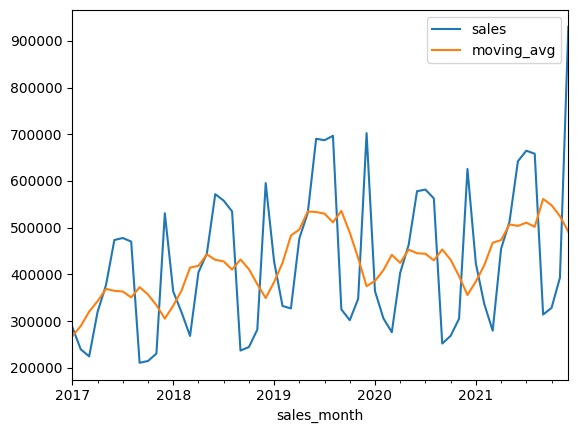

In [8]:
result = %sql select * from moving_averages;
result.set_index("sales_month").plot()

### Cumulative Analysis (MTD/YTD)

An alternative to rolling windows of fixed length is to fix the starting point but have the end point change with the value accumulating over time. Common starting points would be the start of the year for year to date (YTD) or start of the month for month to date (MTD).

In [9]:
%%sql --save cummulative_sales --no-execute
with cte as (
select order_date 
,sum(total) as amt 
from orders group by 1 order by 1 asc
)
select 
order_date 
,amt 
,sum(amt) over (partition by year(order_date), month(order_date) order by order_date) as mtd
,sum(amt) over (partition by year(order_date) order by order_date) as ytd
from cte
group by 1, 2 order by 1; 

Skipping execution...

Generating CTE with stored snippets: 'cummulative_sales'

<Axes: xlabel='order_date'>

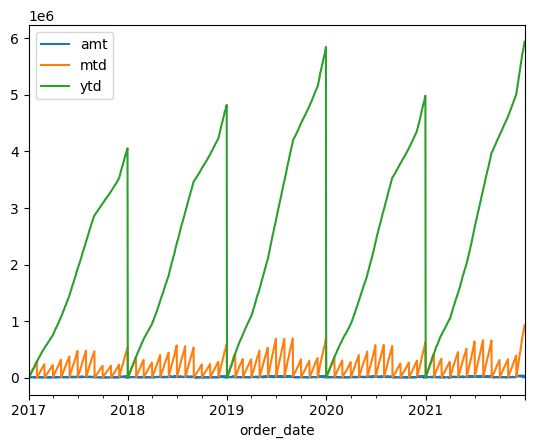

In [10]:
result = %sql select * from cummulative_sales;
result.set_index("order_date").plot()

## Seasonality

Time series analysis is also used to pick up on seasonal cycles. 

To detect these cycles we can plot the periods to compare on the same graph.

### Comparing Multiple Prior Periods

Note how the **partition** clause will order the data by month in the window and the **lag** function is used to index into previous months. 

In [11]:
%%sql --save seasonal_sales --no-execute
select 
sales_month
,sales
,lag(sales,1) over prev_months as prev_sales_1
,lag(sales,2) over prev_months as prev_sales_2
,lag(sales,3) over prev_months as prev_sales_3
,lag(sales,4) over prev_months as prev_sales_4
from sales_monthly
window prev_months as (
    partition by date_part('month',sales_month) 
    order by sales_month
)

Skipping execution...

Generating CTE with stored snippets: 'seasonal_sales'

<Axes: xlabel='sales_month'>

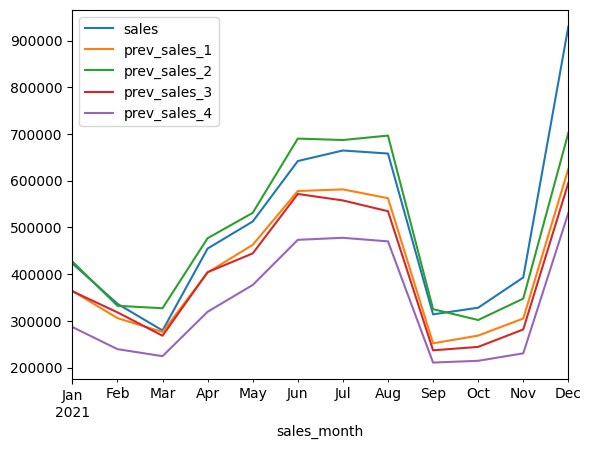

In [12]:
result = %sql select * from seasonal_sales where sales_month >= '2021-01-01' order by sales_month asc;
result.set_index("sales_month").plot()